In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from spectres import spectres
from scipy.constants import c as speed_of_light
from tqdm import tqdm
import prodimopy.read as pread
from numba import njit
from scipy.stats import kendalltau, spearmanr, pearsonr

In [30]:
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux

In [125]:
for gdr in ['100', '1000']:
    with open(f'FLiTsData{gdr}.pkl', 'rb') as f:
        df = pickle.load(f)
    species = ['CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NO', 'O2', 'OH']
    # species = ['HCN']
    c2h2_flux = []
    c2h2_wl = []
    print(df.columns)
    for i, row in tqdm(df.iterrows()):
        n_row, n_col = divmod(i, 5)
        total_FLiTs_flux = df.loc[df['Model Name'] == row['Model Name'], 'FLiTs Flux'].values[0].copy()
        C2H2_flux = total_FLiTs_flux.copy()
        total_FLiTs_wl = df.loc[df['Model Name'] == row['Model Name'], 'FLiTs Wavelength'].values[0].copy()
        mask = ((total_FLiTs_wl >= 6.8) & (total_FLiTs_wl <= 8.2)) | \
           ((total_FLiTs_wl >= 11.1) & (total_FLiTs_wl <= 17.6))
        for specie in species:
            interp_flux = spectres(total_FLiTs_wl, row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux'], fill=0, verbose=False)
            C2H2_flux -= interp_flux
        C2H2_flux = np.where(mask, C2H2_flux, 0)
        c2h2_flux.append(C2H2_flux)
        c2h2_wl.append(total_FLiTs_wl)
    plt.show()
    df['FLiTs C2H2 Wavelength'] = c2h2_wl
    df['FLiTs C2H2 Flux'] = c2h2_flux
    with open(f'FLiTsData{gdr}.pkl', 'wb') as f:
        pickle.dump(df, f)


Index(['Model Name', 'C Value', 'O Value', 'CO Value', 'FLiTs Wavelength',
       'FLiTs Flux', 'FLiTs atomic Flux', 'FLiTs atomic Wavelength',
       'FLiTs CH4 Flux', 'FLiTs CH4 Wavelength', 'FLiTs CO Flux',
       'FLiTs CO Wavelength', 'FLiTs CO2 Flux', 'FLiTs CO2 Wavelength',
       'FLiTs H2O Flux', 'FLiTs H2O Wavelength', 'FLiTs HCN Flux',
       'FLiTs HCN Wavelength', 'FLiTs NH3 Flux', 'FLiTs NH3 Wavelength',
       'FLiTs NO Flux', 'FLiTs NO Wavelength', 'FLiTs O2 Flux',
       'FLiTs O2 Wavelength', 'FLiTs OH Flux', 'FLiTs OH Wavelength'],
      dtype='object')


0it [00:00, ?it/s]C:\Users\Niels de Klerk\PycharmProjects\BRP\.venv\Lib\site-packages\spectres\spectral_resampling.py:141: RuntimeWarning: invalid value encountered in divide
  new_fluxes[..., j] /= np.sum(old_widths[start:stop+1])
25it [06:09, 14.79s/it]


Index(['Model Name', 'C Value', 'O Value', 'CO Value', 'FLiTs Wavelength',
       'FLiTs Flux', 'FLiTs atomic Flux', 'FLiTs atomic Wavelength',
       'FLiTs CH4 Flux', 'FLiTs CH4 Wavelength', 'FLiTs CO Flux',
       'FLiTs CO Wavelength', 'FLiTs CO2 Flux', 'FLiTs CO2 Wavelength',
       'FLiTs H2O Flux', 'FLiTs H2O Wavelength', 'FLiTs HCN Flux',
       'FLiTs HCN Wavelength', 'FLiTs NH3 Flux', 'FLiTs NH3 Wavelength',
       'FLiTs NO Flux', 'FLiTs NO Wavelength', 'FLiTs O2 Flux',
       'FLiTs O2 Wavelength', 'FLiTs OH Flux', 'FLiTs OH Wavelength'],
      dtype='object')


0it [00:00, ?it/s]C:\Users\Niels de Klerk\PycharmProjects\BRP\.venv\Lib\site-packages\spectres\spectral_resampling.py:141: RuntimeWarning: invalid value encountered in divide
  new_fluxes[..., j] /= np.sum(old_widths[start:stop+1])
25it [06:05, 14.63s/it]


In [129]:
with open('FLiTsData100.pkl', 'rb') as f:
    df = pickle.load(f)

Index(['Model Name', 'C Value', 'O Value', 'CO Value', 'FLiTs Wavelength',
       'FLiTs Flux', 'FLiTs atomic Flux', 'FLiTs atomic Wavelength',
       'FLiTs CH4 Flux', 'FLiTs CH4 Wavelength', 'FLiTs CO Flux',
       'FLiTs CO Wavelength', 'FLiTs CO2 Flux', 'FLiTs CO2 Wavelength',
       'FLiTs H2O Flux', 'FLiTs H2O Wavelength', 'FLiTs HCN Flux',
       'FLiTs HCN Wavelength', 'FLiTs NH3 Flux', 'FLiTs NH3 Wavelength',
       'FLiTs NO Flux', 'FLiTs NO Wavelength', 'FLiTs O2 Flux',
       'FLiTs O2 Wavelength', 'FLiTs OH Flux', 'FLiTs OH Wavelength',
       'FLiTs C2H2 Flux'],
      dtype='object')


0it [00:00, ?it/s]C:\Users\Niels de Klerk\PycharmProjects\BRP\.venv\Lib\site-packages\spectres\spectral_resampling.py:141: RuntimeWarning: invalid value encountered in divide
  new_fluxes[..., j] /= np.sum(old_widths[start:stop+1])
25it [06:10, 14.80s/it]


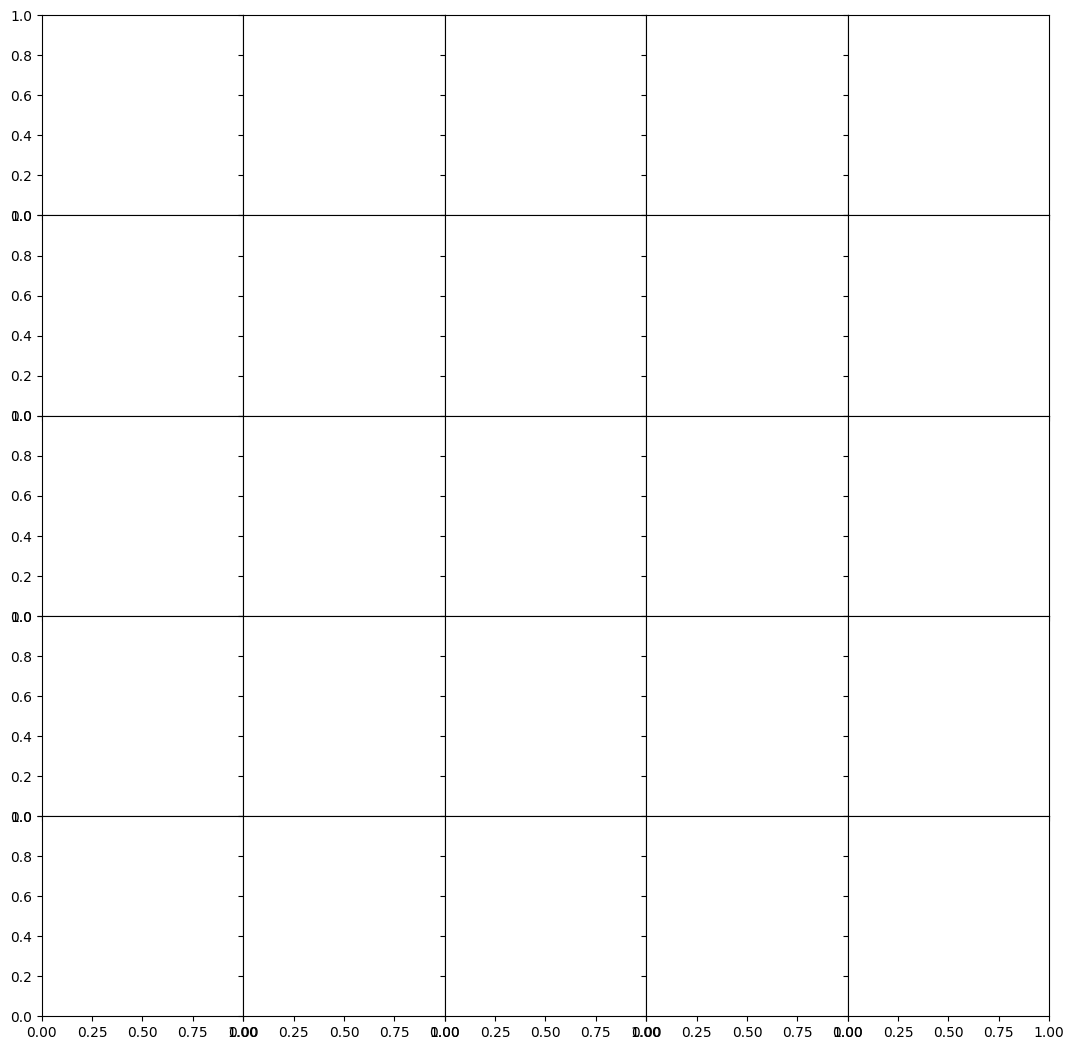

In [104]:
# fig = plt.figure(figsize=(13, 13))
# gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
# axes = gs.subplots(sharex='col', sharey='row').flatten()
species = ['CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NO', 'O2', 'OH']
# species = ['HCN']
c2h2_flux = []
c2h2_wl = []
print(df.columns)
for i, row in tqdm(df.iterrows()):
    n_row, n_col = divmod(i, 5)
    total_FLiTs_flux = df.loc[df['Model Name'] == row['Model Name'], 'FLiTs Flux'].values[0].copy()
    C2H2_flux = total_FLiTs_flux.copy()
    total_FLiTs_wl = df.loc[df['Model Name'] == row['Model Name'], 'FLiTs Wavelength'].values[0].copy()
    mask = ((total_FLiTs_wl >= 6.8) & (total_FLiTs_wl <= 8.2)) | \
       ((total_FLiTs_wl >= 11.1) & (total_FLiTs_wl <= 17.6))
    for specie in species:
        interp_flux = spectres(total_FLiTs_wl, row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux'], fill=0, verbose=False)
        C2H2_flux -= interp_flux
    C2H2_flux = np.where(mask, C2H2_flux, 0)
    c2h2_flux.append(C2H2_flux)
    c2h2_wl.append(total_FLiTs_wl)

plt.show()
df['FLiTs C2H2 Wavelength'] = c2h2_wl
df['FLiTs C2H2 Flux'] = c2h2_flux

In [ ]:
with open(f'FLiTsData{gdr}.pkl', 'wb') as f:
    pickle.dump(df, f)

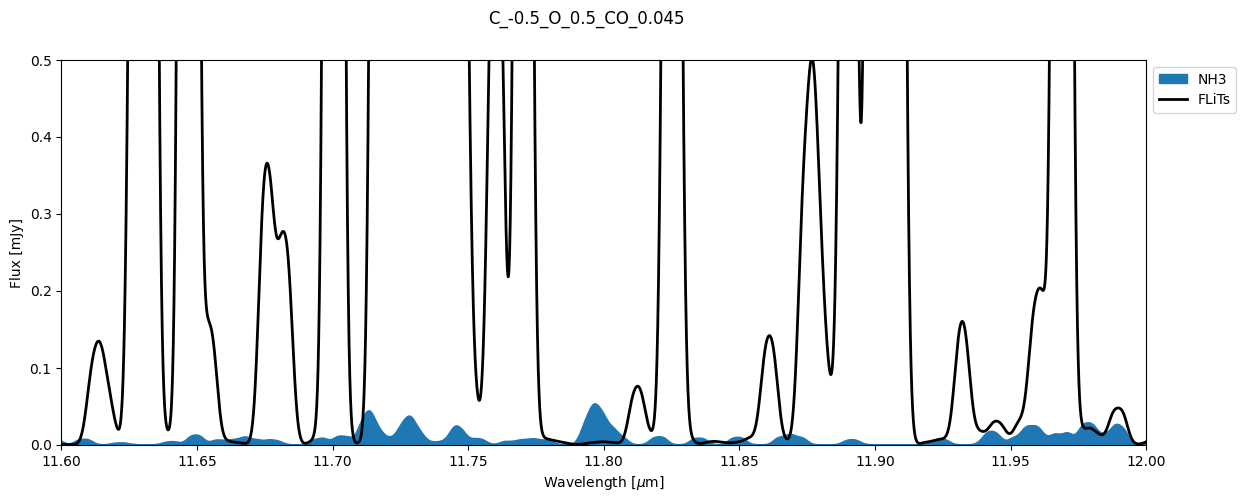

In [130]:
# %matplotlib notebook
plt.close('all')
total_spec = None
cmap = mpl.colormaps.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(14, 5))
species = ['atomic','C2H2','CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
# species = ['atomic', 'CH4',  'CO', 'CO2', 'HCN', 'NH3', 'NO', 'O2', 'OH']
species =['NH3']
model = df['Model Name'][4]
FLiTs_wl = df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy()
FLiTs_flux = df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy()
for index, specie in enumerate(species):
    specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
    specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
    # new_specie_flux = np.interp(FLiTs_wl, specie_wl, specie_flux, left=0, right=0)
    # if total_spec is None:
    #     total_spec = new_specie_flux
    # else:
    #     total_spec += new_specie_flux
    # ax.fill_between(FLiTs_wl, 0, total_spec*1000, label=specie, zorder=len(species) - index+1,
    #                 color=cmap(index / len(species)))
    ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
                    color=cmap(index / len(species)))
ax.plot(FLiTs_wl, FLiTs_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
specie = 'CO'
specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
# ax.plot(specie_wl, specie_flux)
# ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
fig.suptitle(model)
ax.set_ylabel('Flux [mJy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim([11.6, 12])
ax.set_ylim(0,0.5)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig(f'Spectrum{model}.png')
plt.show()

6.125, 11.8

        atomic   CH4    CO   CO2   H2O   HCN   NH3    NO    O2    OH
atomic    1.00  0.02 -0.04 -0.67 -0.53  0.55 -0.28 -0.44 -0.47 -0.42
CH4       0.02  1.00  0.78 -0.04 -0.37  0.37 -0.69 -0.45 -0.31 -0.51
CO       -0.04  0.78  1.00  0.06 -0.29  0.27 -0.59 -0.37 -0.20 -0.42
CO2      -0.67 -0.04  0.06  1.00  0.64 -0.66  0.31  0.51  0.56  0.49
H2O      -0.53 -0.37 -0.29  0.64  1.00 -0.94  0.67  0.86  0.82  0.84
HCN       0.55  0.37  0.27 -0.66 -0.94  1.00 -0.65 -0.85 -0.84 -0.83
NH3      -0.28 -0.69 -0.59  0.31  0.67 -0.65  1.00  0.75  0.61  0.82
NO       -0.44 -0.45 -0.37  0.51  0.86 -0.85  0.75  1.00  0.83  0.89
O2       -0.47 -0.31 -0.20  0.56  0.82 -0.84  0.61  0.83  1.00  0.79
OH       -0.42 -0.51 -0.42  0.49  0.84 -0.83  0.82  0.89  0.79  1.00


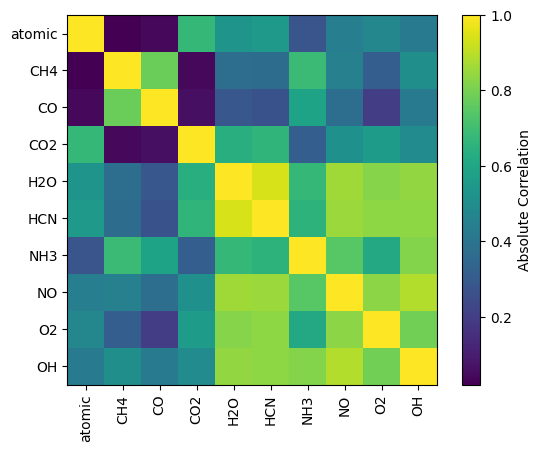

In [94]:
data = []
species = ['atomic', 'CH4', 'CO', 'CO2', 'H2O', 'HCN','NH3', 'NO', 'O2', 'OH']
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux']))
    data.append(fluxes)
df_FLiTs_flux = pd.DataFrame(data, columns=species)
print(df_FLiTs_flux.corr(method='kendall').round(2))
plt.imshow(abs(df_FLiTs_flux.corr(method='kendall')), cmap=plt.get_cmap("viridis")) # method='kendall'
plt.xticks(ticks=np.arange(len(species)), labels=species, rotation=90)
plt.yticks(ticks=np.arange(len(species)), labels=species)
plt.colorbar(label='Absolute Correlation')
plt.show()

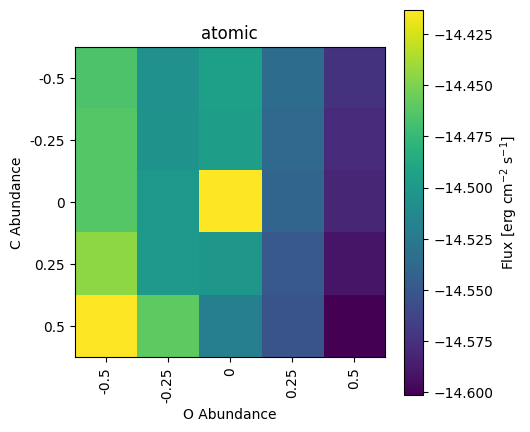

C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_23340\584247901.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(df_FLiTs_flux[specie].values.reshape(5,5)), cmap='viridis')


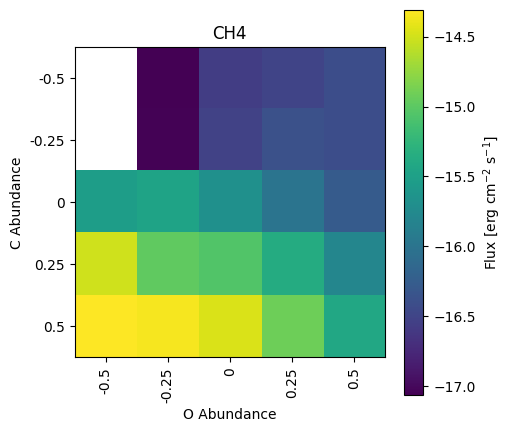

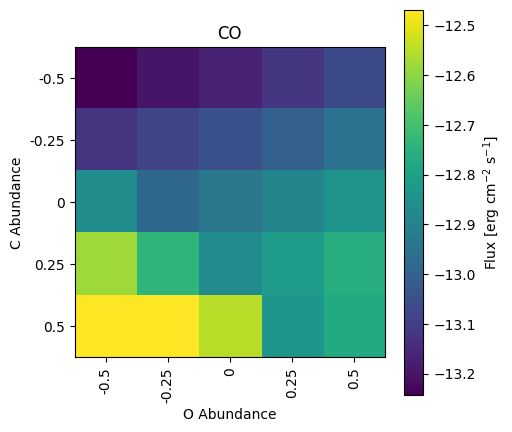

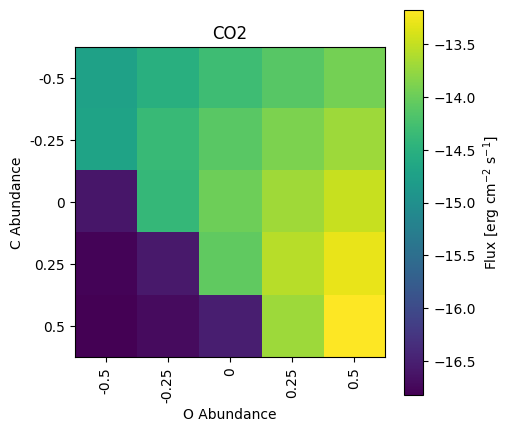

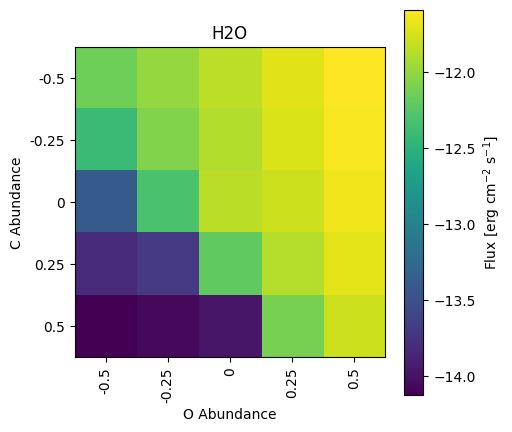

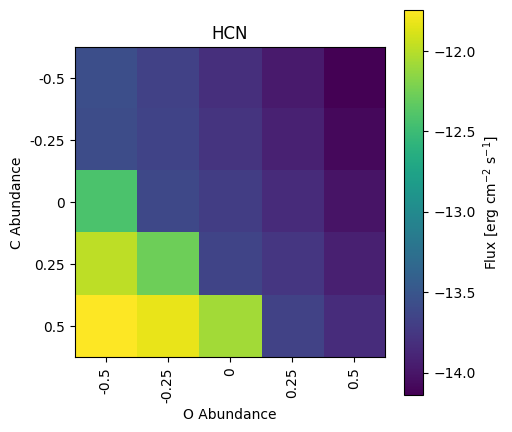

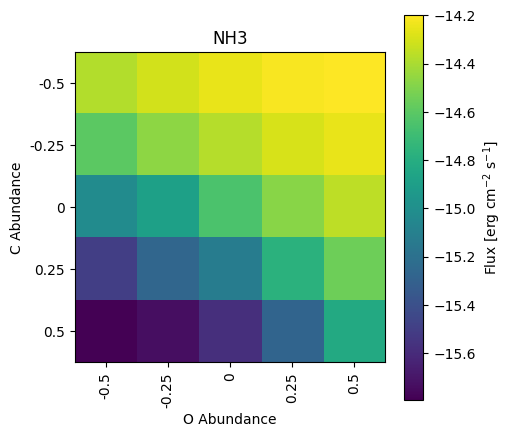

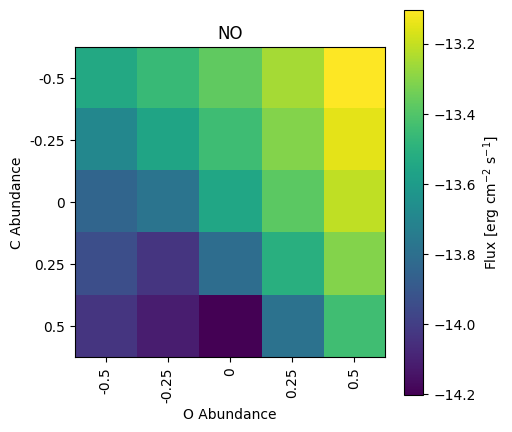

C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_23340\584247901.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(df_FLiTs_flux[specie].values.reshape(5,5)), cmap='viridis')


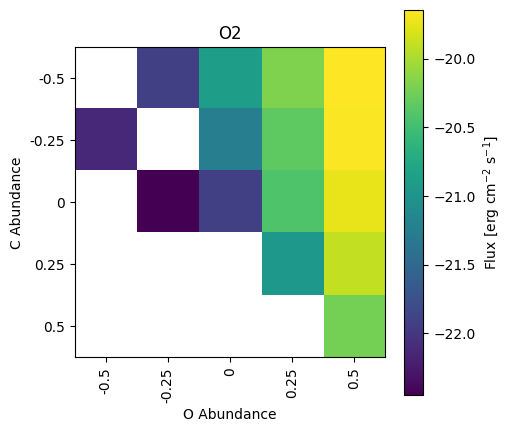

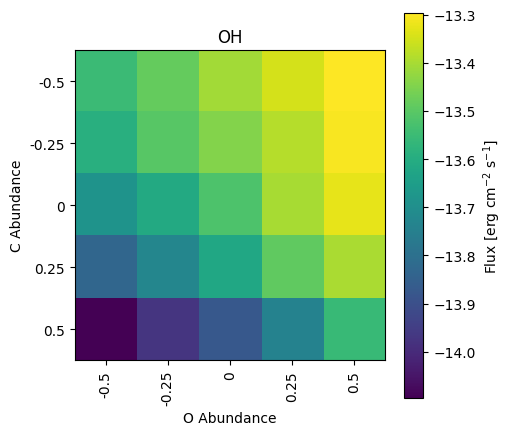

In [96]:

for specie in species:
    plt.figure(figsize=(5, 5))
    plt.imshow(np.log10(df_FLiTs_flux[specie].values.reshape(5,5)), cmap='viridis')
    plt.title(specie)
    plt.xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    plt.yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    plt.xlabel('O Abundance')
    plt.ylabel('C Abundance')
    plt.colorbar(label='Flux [erg cm$^{-2}$ s$^{-1}$]')
    # plt.savefig(f'Flux_{specie}.png')
    plt.show()